## PHYS-243 Spring 2019 - Brandon Evans - Homework 6
#### Dr. Mobasher, TA Abtin Shahidi <br> 13-Jun-2019<br>
Using some of Abtin's Keras examples from Week 8 Notebook

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from scipy.stats import zscore
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#### Let's label and load the data

In [4]:
label_array = ['x1','x2','class']
DATA_FILE = 'train_set.txt'
df = pd.read_csv(DATA_FILE, delimiter=',', header=None, names=label_array)

In [3]:
#What's our response variable look like?
df['class'].value_counts()

r    585
g     50
b     50
Name: class, dtype: int64

In [4]:
df.describe()

,x1,x2
count,685.000000,685.000000
mean,0.596296,1.079071
std,18.941957,18.789436
min,-54.531886,-57.232861
25%,-16.376391,-14.788019
50%,0.387794,0.474620
75%,17.255583,16.628887
max,58.905065,60.321524


#### Visualize the data

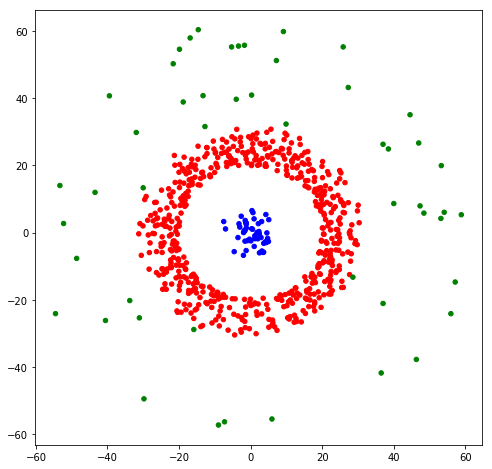

In [5]:
plt.figure(figsize=(8,8))
plt.scatter(df['x1'], df['x2'], c=df['class'], s = 20)#, alpha=0.2)

#### Compute additional features
$X3 = X_1^2$<br>
$X4 = X_2^2$<br>
$X5 = X_1X_2$<br>

In [6]:
df['x3'] = df['x1']**2
df['x4'] = df['x2']**2
df['x5'] = df['x1']*df['x2']

In [ ]:
df.head()

#### Try neural nets with different feature sets
1. {X3, X4}
2. {X3, X5}
3. {X3, X4, X5}
4. {X1, X2, X3, X4, X5}

#### Configure our dataset - Scaling, Split input/output variables

In [7]:
X_raw = df.drop(columns='class')
n_features = X_raw.shape[1]
n_classes = df['class'].nunique()

#Scale the input features
X = X_raw.apply(zscore)

#Encode the output variable
Y = pd.get_dummies(df['class'])

print("Input Features:{}".format(n_features))
print("Output Classes:{}".format(n_classes))

Input Features:5
Output Classes:3


In [8]:
# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.15)

In [41]:
from keras.models import Sequential
from keras.layers import Dense

def create_custom_model(input_dim, output_dim, neurons, layers=1,hidden_activation='softmax', name='model'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        for i in range(layers):
            model.add(Dense(neurons, input_dim=input_dim, activation='relu'))
        model.add(Dense(output_dim, activation=hidden_activation))

        # Compile model
        model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        return model
    return create_model

#models = [create_custom_model(n_features, n_classes, 8, i, 'model{}'.format(i)) 
#          for i in range(1, 4)]

#for create_model in models:
#    create_model().summary()

#### Abtin's code to iterate and define models varying from 1 to 3 dense (fully-connected) layers

In [37]:
models = [create_custom_model(n_features, n_classes, 8, i, 'softmax', 'model{}'.format(i)) 
          for i in range(1, 4)]
BuildModels(models)

Model name: model1
Test Accuracy:0.9902912621359223  Loss:0.045706098284391525
Model name: model2
Test Accuracy:0.9902912621359223  Loss:0.07554712222473135
Model name: model3
Test Accuracy:0.9902912621359223  Loss:0.03955592321304297


#### Train the multiple models

In [49]:
from keras.callbacks import TensorBoard

history_dict = {}

def BuildModels(models):
    global history_dict
    history_dict = {}

    # TensorBoard Callback
    cb = TensorBoard()

    for create_model in models:
        model = create_model()
        history_callback = model.fit(X_train, Y_train,
                                     batch_size=5,
                                     epochs=50,
                                     verbose=0,
                                     validation_data=(X_test, Y_test),
                                     callbacks=[cb])
        score = model.evaluate(X_test, Y_test, verbose=0)
        print('({}) Test Accuracy:{}  Loss:{}'.format(model.name,round(score[1],4),round(score[0],4)))
        history_dict[model.name] = [history_callback, model]

#### Visualize model performance
* This code kept crashing my jupyter kernel, very strange.  Like a libary conflict
* Indeed, I found Mac users have similar issues: https://github.com/dmlc/xgboost/issues/1715
```
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
```

In [1]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

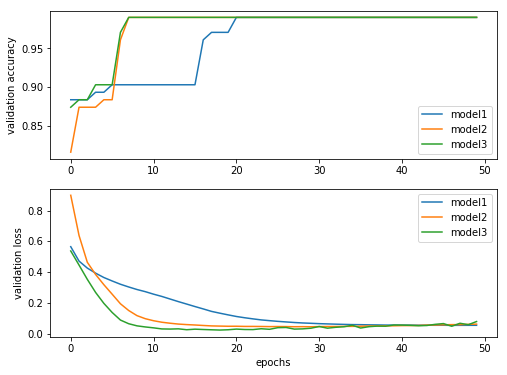

In [16]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))
for model_name in history_dict:
    val_acc = history_dict[model_name][0].history['val_acc']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_acc, label=model_name)
    ax2.plot(val_loss, label=model_name)
    
ax1.set_ylabel(r'validation accuracy')
ax2.set_ylabel(r'validation loss')
ax2.set_xlabel(r'epochs')
ax1.legend()
ax2.legend()
plt.show()

#### Let's now tune some parameters and see the best performance we can get with the simplest network...
* Activations: Sigmoid, Softmax, TanH
* Layers: 1 to 4
* Neurons/Layer: 4 to 12

In [47]:
layers = [1,2,3,4]
neurons = [4,6,8]
activations = ['sigmoid','softmax','tanh']

i=1
models = list()
for activation in activations:
    for layer in layers:
        for neuron in neurons:       
            print('model{} Layers:{} Neurons:{} Activation:{}'.format(i,layer,neuron,activation))
            models.append(create_custom_model(n_features, n_classes, neuron, layer, activation, 'model{}'.format(i)))
            i+=1

model1 Layers:1 Neurons:4 Activation:sigmoid
model2 Layers:1 Neurons:6 Activation:sigmoid
model3 Layers:1 Neurons:8 Activation:sigmoid
model4 Layers:2 Neurons:4 Activation:sigmoid
model5 Layers:2 Neurons:6 Activation:sigmoid
model6 Layers:2 Neurons:8 Activation:sigmoid
model7 Layers:3 Neurons:4 Activation:sigmoid
model8 Layers:3 Neurons:6 Activation:sigmoid
model9 Layers:3 Neurons:8 Activation:sigmoid
model10 Layers:4 Neurons:4 Activation:sigmoid
model11 Layers:4 Neurons:6 Activation:sigmoid
model12 Layers:4 Neurons:8 Activation:sigmoid
model13 Layers:1 Neurons:4 Activation:softmax
model14 Layers:1 Neurons:6 Activation:softmax
model15 Layers:1 Neurons:8 Activation:softmax
model16 Layers:2 Neurons:4 Activation:softmax
model17 Layers:2 Neurons:6 Activation:softmax
model18 Layers:2 Neurons:8 Activation:softmax
model19 Layers:3 Neurons:4 Activation:softmax
model20 Layers:3 Neurons:6 Activation:softmax
model21 Layers:3 Neurons:8 Activation:softmax
model22 Layers:4 Neurons:4 Activation:softm

In [48]:
BuildModels(models)

(model1) Test Accuracy:0.9903  Loss:0.0754
(model2) Test Accuracy:0.9903  Loss:0.0913
(model3) Test Accuracy:0.9903  Loss:0.048
(model4) Test Accuracy:0.9903  Loss:0.0636
(model5) Test Accuracy:0.9903  Loss:0.0697
(model6) Test Accuracy:0.9417  Loss:0.0794
(model7) Test Accuracy:0.9223  Loss:0.3102
(model8) Test Accuracy:0.9903  Loss:0.0341
(model9) Test Accuracy:0.9903  Loss:0.1587
(model10) Test Accuracy:0.9612  Loss:0.2566
(model11) Test Accuracy:0.9903  Loss:0.1573
(model12) Test Accuracy:0.9903  Loss:0.1453
(model13) Test Accuracy:0.9903  Loss:0.0537
(model14) Test Accuracy:0.9903  Loss:0.0514
(model15) Test Accuracy:0.9903  Loss:0.0337
(model16) Test Accuracy:0.9903  Loss:0.0619
(model17) Test Accuracy:0.9903  Loss:0.0367
(model18) Test Accuracy:0.9903  Loss:0.0555
(model19) Test Accuracy:0.9903  Loss:0.0501
(model20) Test Accuracy:0.9903  Loss:0.0269
(model21) Test Accuracy:0.9903  Loss:0.0792
(model22) Test Accuracy:0.9709  Loss:0.0873
(model23) Test Accuracy:0.9903  Loss:0.148

#### Conclusions
* Neural network provided high degree of accuracy for little complexity
* Softmax activation had lowest validation loss and best accuracy
* Achieved 0.9903 accuracy and 0.0269 loss with 3 layers, 6 neuron/layer and softmax activation.  This will be my selected parameters for Abtin's hidden test data set

In [ ]:
final = list()
final.append(create_custom_model(n_features, n_classes, 6, 3, 'softmax', 'brandon'))
BuildModels(final)